In [1]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [3]:
Batch_Size=148
Image_Size=256
Channels=3
Epochs=50

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "D:/VSCode/AI & ML Project/Dataset/Tomato",
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size= Batch_Size

)

Found 14835 files belonging to 10 classes.


In [13]:
class_names= dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

(148, 256, 256, 3)
[9 9 6 2 7 0 0 0 3 9 2 3 5 0 1 2 3 2 7 2 7 5 1 7 6 2 4 9 7 6 0 4 0 7 4 0 7
 2 4 4 6 7 1 5 9 5 0 0 2 9 4 5 4 0 7 6 4 6 1 1 5 6 4 6 0 5 5 2 1 6 4 3 2 5
 2 6 7 6 6 2 1 5 7 2 3 4 7 7 5 4 0 9 0 5 3 7 3 1 9 2 2 0 0 4 4 7 0 3 7 5 3
 9 9 7 6 7 3 4 5 2 4 0 7 5 7 4 5 8 4 0 7 7 9 4 4 0 0 4 0 9 6 5 0 9 2 3 4 2]


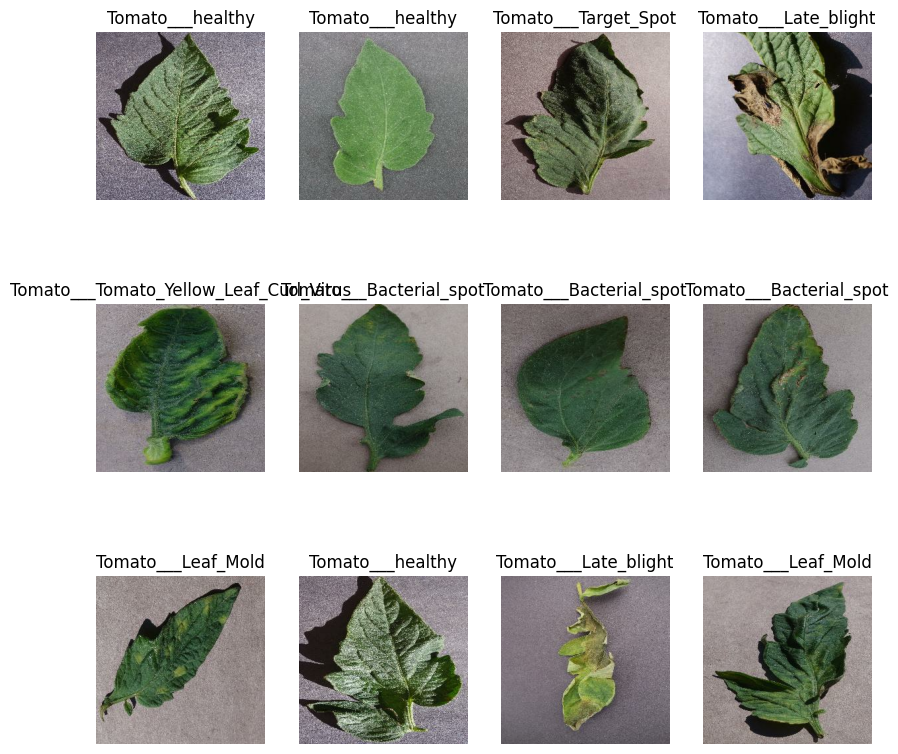

In [14]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        

In [15]:
train_size=0.8
len(dataset)*train_size

80.80000000000001

In [16]:
train_ds= dataset.take(80)
len(train_ds)

80

In [17]:
test_ds=dataset.skip(80)
len(test_ds)

21

In [18]:
val_ds=test_ds.take(10)
len(val_ds)

10

In [19]:
test_ds=test_ds.skip(10)
len(test_ds)

11

In [5]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds


In [6]:
train_ds,test_ds,val_ds = get_dataset_split(dataset)

In [23]:
print(len(train_ds),len(test_ds),len(val_ds))

80 11 10


In [7]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#loading to cache memory to reduce training time
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),#resizing
    layers.experimental.preprocessing.Rescaling(1.0/255)#normalizing
]
)

In [10]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

In [27]:
input_shape=(Batch_Size,Image_Size,Image_Size,Channels)
n_classes=10
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),#relu makes model non linear by converting negative values in feature map to 0
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (148, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (148, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (148, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (148, 127, 127, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (148, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (148, 62, 62, 64)         0         
 g2D)                                                 

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
data=model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs
)

Epoch 1/50
80/80 [==============================] - 751s 9s/step - loss: 2.1429 - accuracy: 0.2122 - val_loss: 2.0228 - val_accuracy: 0.2473
Epoch 2/50
80/80 [==============================] - 459s 6s/step - loss: 1.7742 - accuracy: 0.3891 - val_loss: 1.4696 - val_accuracy: 0.4946
Epoch 3/50
80/80 [==============================] - 440s 5s/step - loss: 1.4567 - accuracy: 0.4944 - val_loss: 1.3455 - val_accuracy: 0.5236
Epoch 4/50
80/80 [==============================] - 441s 6s/step - loss: 1.2781 - accuracy: 0.5527 - val_loss: 1.3568 - val_accuracy: 0.5182
Epoch 5/50
80/80 [==============================] - 439s 5s/step - loss: 1.0894 - accuracy: 0.6183 - val_loss: 1.1689 - val_accuracy: 0.6000
Epoch 6/50
80/80 [==============================] - 439s 5s/step - loss: 0.9475 - accuracy: 0.6621 - val_loss: 1.2662 - val_accuracy: 0.6068
Epoch 7/50
80/80 [==============================] - 443s 6s/step - loss: 0.8586 - accuracy: 0.6982 - val_loss: 1.2705 - val_accuracy: 0.6081
Epoch 8/50
80

In [31]:
model.save("models/{'tomato'}")

INFO:tensorflow:Assets written to: models/{'tomato'}\assets


INFO:tensorflow:Assets written to: models/{'tomato'}\assets


In [11]:
model=tf.keras.models.load_model("D:/VSCode/AI & ML Project/models/tomato")

In [12]:
scores=model.evaluate(test_ds)

11/11 [==============================] - 78s 2s/step - loss: 0.4120 - accuracy: 0.8839


In [35]:
data.history['accuracy']

[0.21215997636318207,
 0.3891020715236664,
 0.4944145977497101,
 0.552741527557373,
 0.6183167099952698,
 0.6621471643447876,
 0.6982178092002869,
 0.73565274477005,
 0.7488701343536377,
 0.7669480443000793,
 0.7936385869979858,
 0.8002899289131165,
 0.8177709579467773,
 0.8216935396194458,
 0.8375543355941772,
 0.846678614616394,
 0.8543531894683838,
 0.8604075908660889,
 0.8639891147613525,
 0.8837724924087524,
 0.887183427810669,
 0.892982006072998,
 0.8815553784370422,
 0.8982689380645752,
 0.8975867629051208,
 0.907649040222168,
 0.9141297936439514,
 0.9178817868232727,
 0.9103777408599854,
 0.919331431388855,
 0.9154941439628601,
 0.9132770299911499,
 0.9311844706535339,
 0.9333162903785706,
 0.9156647324562073,
 0.9212927222251892,
 0.9361302852630615,
 0.9267502427101135,
 0.9220601916313171,
 0.932463526725769,
 0.9352775812149048,
 0.9414172172546387,
 0.9328046441078186,
 0.946618914604187,
 0.940308690071106,
 0.9449987411499023,
 0.9423552751541138,
 0.9433785080909729,
 0

In [82]:
filename = "D:/VSCode/AI & ML Project/Dataset/Tomato/Tomato___Bacterial_spot/00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG"
# AI & ML Project/Dataset/Tomato/Tomato___Bacterial_spot/00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG
def process_image(image_path):
    # Load and preprocess the image for your model
    img = Image.open(image_path)
    img = img.resize((256, 256))  # adjust the size according to your model's input
    img_array = np.array(img) / 255.0  # normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    return img_array

img_array = process_image(filename)
batch_prediction= model.predict(img_array)
print("Predicted Disease",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 88ms/step
Predicted Disease Tomato___Late_blight
